# Draw an isochrone map with OSMnx

Author: [Geoff Boeing](https://geoffboeing.com/)

How far can you travel on foot in 15 minutes?

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
# configure the place, network type, trip times, and travel speed
place = 'Dolgoprudny, Russia'
network_type = 'walk'
trip_times = [5, 10, 15, 20] #in minutes
travel_speed = 4.5 #walking speed in km/hour

## Download and prep the street network

In [4]:
# download the street network
G = ox.graph_from_place(place, network_type=network_type)

In [5]:
bbox = (37.463342, 55.75, 37.497268, 55.768317)
G = ox.graph.graph_from_bbox(bbox, network_type=network_type, simplify=False)

In [6]:
exit = (55.761911, 37.472648)
G = ox.graph_from_point(exit, dist=travel_speed * 1000 / 60 * 20 + 10, dist_type='network', network_type=network_type, simplify=False)

In [7]:
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
gdf_nodes['geometry'].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
# find the centermost node and then project the graph to UTM
crs = "EPSG:4326"
# crs = "EPSG:32637"

exits = [(55.761911, 37.472648), (55.762921, 37.496033)]

G = ox.project_graph(G, to_crs=crs)
exit_nodes = []
for exit in exits:
    x, y = ox.projection.project_geometry(Point(exit[1], exit[0]), crs="EPSG:4326", to_crs=crs)[0].xy
    exit_node = ox.distance.nearest_nodes(G, x[0], y[0])
    exit_nodes.append(exit_node)

G = ox.project_graph(G)

In [9]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

## Plots nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [10]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0)

In [11]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')

NameError: name 'center_node' is not defined

## Plot the time-distances as isochrones

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

In [ ]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).union_all().convex_hull
    isochrone_polys.append(bounding_poly)

In [ ]:
isochrone_polys = [x for x in isochrone_polys if type(x) == Polygon]
isochrone_polys

In [ ]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

[<POLYGON ((403664.335 6179555.503, 403661.882 6179555.55, 403659.445 6179555...>, <POLYGON ((403855.92 6179807.031, 403853.483 6179807.315, 403851.086 6179807...>, <POLYGON ((404020.143 6180005.829, 404018.372 6180004.131, 404016.443 618000...>, <POLYGON ((404117.607 6180460.486, 404116.328 6180458.392, 404114.85 6180456...>]


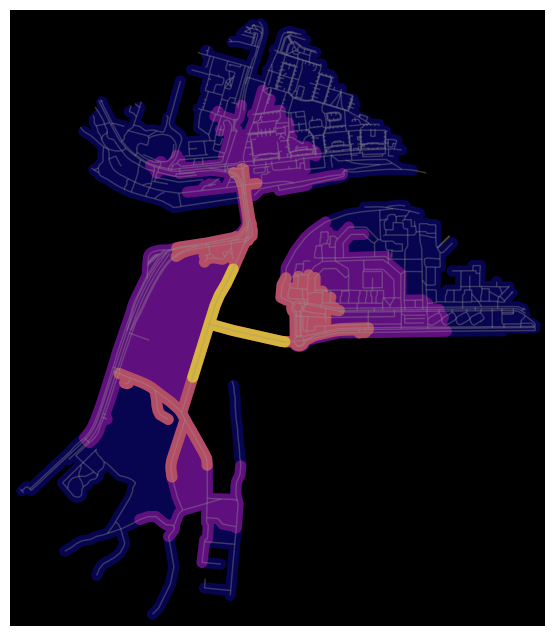

[<POLYGON ((404561.698 6180587.047, 404560.89 6180587.209, 404560.504 6180587...>, <POLYGON ((404581.459 6180585.818, 404580.76 6180585.703, 404580.242 6180585...>, <POLYGON ((404941.351 6180649.197, 404938.919 6180649.52, 404936.531 6180650...>, <POLYGON ((405371.837 6180683.528, 405370.807 6180683.098, 405369.781 618068...>]


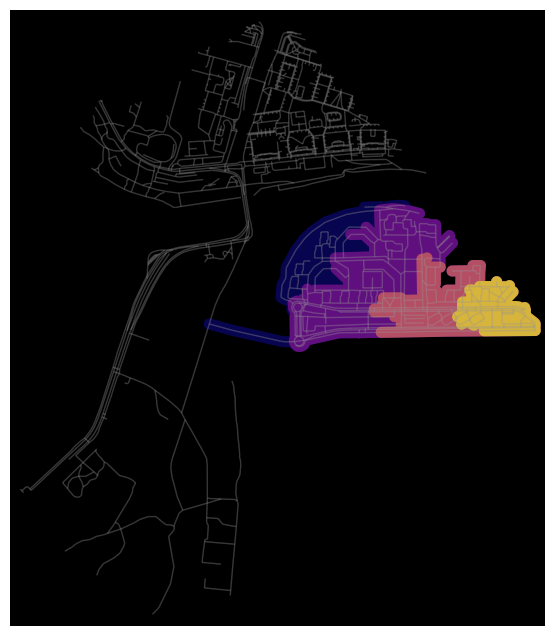

In [12]:
def make_iso_polys(G, center_node, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).union_all()

        if type(new_iso) != Polygon:
            continue
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


all_iso_polys = []
for exit_node in exit_nodes:
    isochrone_polys = make_iso_polys(G, exit_node, edge_buff=25, node_buff=0, infill=True)
    isochrone_polys = isochrone_polys + [Polygon()] * (len(trip_times) - len(isochrone_polys))
    print(isochrone_polys)
    all_iso_polys.append(isochrone_polys)

    fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                            node_size=0, bgcolor='k')
    for polygon, fc in zip(isochrone_polys, iso_colors):
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
    
    plt.show()

In [33]:
import shapely
isochrones = []
for i in range(len(trip_times)):
    isochrones.append(shapely.union_all([iso_polys[i] for iso_polys in all_iso_polys]))
isochrones

[<POLYGON ((403661.882 6179555.55, 403659.445 6179555.837, 403657.048 6179556...>,
 <POLYGON ((403853.483 6179807.315, 403851.086 6179807.837, 403848.752 617980...>,
 <MULTIPOLYGON (((404018.372 6180004.131, 404016.443 6180002.615, 404014.375 ...>,
 <MULTIPOLYGON (((404116.328 6180458.392, 404114.85 6180456.434, 404113.187 6...>]

In [22]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from numpy import asarray, concatenate, ones


class Polygon(object):
    # Adapt Shapely or GeoJSON/geo_interface polygons to a common interface
    def __init__(self, context):
        if isinstance(context, dict):
            self.context = context['coordinates']
        else:
            self.context = context

    @property
    def exterior(self):
        return (getattr(self.context, 'exterior', None)
                or self.context[0])

    @property
    def interiors(self):
        value = getattr(self.context, 'interiors', None)
        if value is None:
            value = self.context[1:]
        return value

def PolygonPath(polygon):
    """Constructs a compound matplotlib path from a Shapely or GeoJSON-like
    geometric object"""

    def coding(ob):
        # The codes will be all "LINETO" commands, except for "MOVETO"s at the
        # beginning of each subpath
        n = len(getattr(ob, 'coords', None) or ob)
        vals = ones(n, dtype=Path.code_type) * Path.LINETO
        vals[0] = Path.MOVETO
        return vals

    if hasattr(polygon, 'geom_type'):  # Shapely
        ptype = polygon.geom_type
        if ptype == 'Polygon':
            polygon = [Polygon(polygon)]
        elif ptype == 'MultiPolygon':
            polygon = [Polygon(p) for p in polygon]
        else:
            raise ValueError(
                "A polygon or multi-polygon representation is required")

    else:  # GeoJSON
        polygon = getattr(polygon, '__geo_interface__', polygon)
        ptype = polygon["type"]
        if ptype == 'Polygon':
            polygon = [Polygon(polygon)]
        elif ptype == 'MultiPolygon':
            polygon = [Polygon(p) for p in polygon['coordinates']]
        else:
            raise ValueError(
                "A polygon or multi-polygon representation is required")

    print(polygon[0])

    vertices = concatenate([
        concatenate([asarray(t.exterior.coords)[:, :2]] +
                    [asarray(r)[:, :2] for r in t.interiors])
        for t in polygon])
    codes = concatenate([
        concatenate([coding(t.exterior.coords)] +
                    [coding(r) for r in t.interiors]) for t in polygon])

def PolygonPatch(polygon, **kwargs):
    """Constructs a matplotlib patch from a geometric object

    The `polygon` may be a Shapely or GeoJSON-like object with or without holes.
    The `kwargs` are those supported by the matplotlib.patches.Polygon class
    constructor. Returns an instance of matplotlib.patches.PathPatch.

    Example (using Shapely Point and a matplotlib axes):

      >>> b = Point(0, 0).buffer(1.0)
      >>> patch = PolygonPatch(b, fc='blue', ec='blue', alpha=0.5)
      >>> axis.add_patch(patch)

    """
    return PathPatch(PolygonPath(polygon), **kwargs)

In [30]:
from shapely import MultiPolygon

In [35]:
for i in range(len(isochrones)):
    if type(isochrones[i]) != MultiPolygon:
        isochrones[i] = MultiPolygon([isochrones[i]])

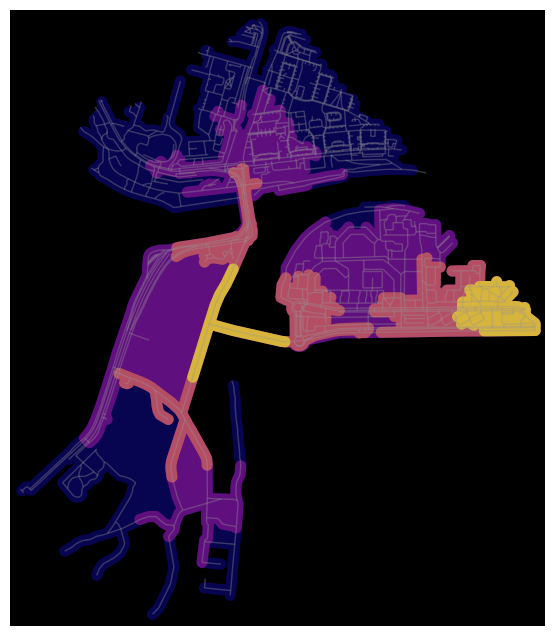

In [38]:
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                            node_size=0, bgcolor='k')

# for polygon, fc in zip(isochrones, iso_colors):
#     patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
#     ax.add_patch(patch)

for polygon, fc in zip(isochrones, iso_colors):
    for geom in polygon.geoms:    
        xs, ys = geom.exterior.xy 
        ax.fill(xs, ys, fc=fc, ec='none', alpha=0.6, zorder=-1)

plt.show()

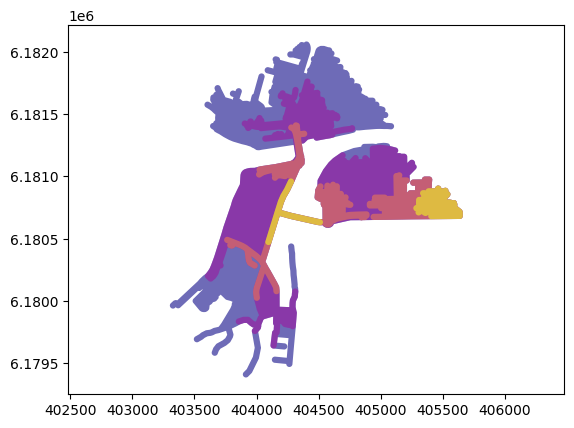

In [37]:
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

for polygon, fc in zip(isochrones, iso_colors):
    for geom in polygon.geoms:    
        xs, ys = geom.exterior.xy 
        axs.fill(xs, ys, fc=fc, ec='none', alpha=0.6, zorder=-1)

plt.show()